In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from grav_lens.models.load_models import load_minmaxscaler, load_ipca_low
# Cargar el MinMaxScaler
minmaxscaler = load_minmaxscaler()
print(minmaxscaler)
# Cargar el modelo IPCA low
ipca_low = load_ipca_low()
print(ipca_low)


import grav_lens.preprocess as gp
from grav_lens.utils.statistics import get_stats
from grav_lens.preprocess.filtering import process_batch_filters


from grav_lens import get_datasets
max_files = 2000
batch_size = 64
home_data = os.path.join("..","data")

train_dataset, val_dataset, test_dataset = get_datasets(
    data_index=1,
    max_files=max_files,
    home=home_data,
    batch_size=batch_size,
    val_split=0.2,
    test_split=0.1,
)

for X_batch, y_batch in train_dataset.take(1):
    print(X_batch.shape)
    print(y_batch.shape)



IncrementalPCA(batch_size=64, n_components=64)
Using data folder: ..\data\1
(64, 128, 128, 3)
(64, 128, 128, 1)


In [3]:
from grav_lens.preprocess.gmm import reconstruct_image_from_gmm, reconstruct_lowfreq_from_pca, reconstruct_batch_images

In [4]:
def preprocess_ybatch(y_batch):
    low_batch, high_batch = process_batch_filters(y_batch)

    gaussians = gp.gmm_batch_vectors(high_batch)

    low_freq_stack = np.vstack([img.reshape(-1, 128*128) for img in low_batch]) #stack para el pca
    principal_components = ipca_low.transform(low_freq_stack)
    return [principal_components, gaussians]

# Histogramas Vectores

In [8]:
import matplotlib.pyplot as plt

def plot_histograms(principal_components, gaussians):
    """
    Dibuja histogramas de los valores de principal_components y de los 5 componentes de las gaussianas.
    
    Parámetros:
        principal_components (numpy array): Array de coeficientes principales de PCA.
        gaussians (numpy array): Array con los vectores de las gaussianas con formato (mean_x, mean_y, std_x, std_y, weight).
    """
    # Plot histogram for principal components
    plt.figure(figsize=(10, 5))
    plt.hist(principal_components.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Histogram of Principal Components')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    # Plot histograms for each of the 5 Gaussian vector components
    gaussian_labels = ['mean_x', 'mean_y', 'std_x', 'std_y', 'weight']
    plt.figure(figsize=(15, 10))
    
    for i in range(5):
        plt.subplot(3, 2, i + 1)
        plt.hist(gaussians[..., i].flatten(), bins=50, alpha=0.7, edgecolor='black')
        plt.title(f'Histogram of {gaussian_labels[i]}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()


In [3]:
gp.gmm_batch_vectors?

Signature:
gp.gmm_batch_vectors(
    batch,
    n_gaussians_positive=30,
    n_gaussians_negative=10,
    threshold=2,
    n_points=500,
    scale=0.5,
    density_threshold=0.05,
    density_scaling=True,
    pos_reg_covar=1e-06,
    pos_tol=0.001,
    neg_reg_covar=1e-06,
    neg_tol=0.001,
)
Docstring:
Aplica modelos de mezclas gaussianas (GMM) a un batch de imágenes escaladas, generando vectores de medias, desviaciones estándar y pesos.
Luego, reescala las gaussianas para que correspondan a la resolución original y las ordena por la magnitud de sus pesos.


Esta función primero reduce la resolución de las imágenes de entrada, aplica un modelo GMM para extraer las componentes gaussianas
positivas y negativas, y finalmente reescala las gaussianas a la resolución original. Se usa para aproximar las distribuciones
de alta y baja frecuencia en las imágenes.

Parámetros:
    batch (numpy.ndarray):  Batch de imágenes a procesar con shape (batch_size, altura, anchura, 1).
    n_gaussians_p

# Visualización

In [5]:
for X_batch, y_batch in train_dataset.take(1):
    y_batch = minmaxscaler.transform(y_batch) # [0, 1] #escalar los datos

    print(X_batch.shape)
    print(y_batch.shape)
    
    low_batch, high_batch = process_batch_filters(y_batch)

    gaussians = gp.gmm_batch_vectors(high_batch, 40, 0, 1)

    low_freq_stack = np.vstack([img.reshape(-1, 128*128) for img in low_batch]) #stack para el pca
    principal_components = ipca_low.transform(low_freq_stack)


(64, 128, 128, 3)
(64, 128, 128, 1)


c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (32) found smaller than n_clusters (40). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (26) found smaller than n_clusters (40). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (23) found smaller than n_clusters (40). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (39) found smaller than n_clusters (

In [6]:
from skimage.feature import peak_local_max

In [16]:
import grav_lens




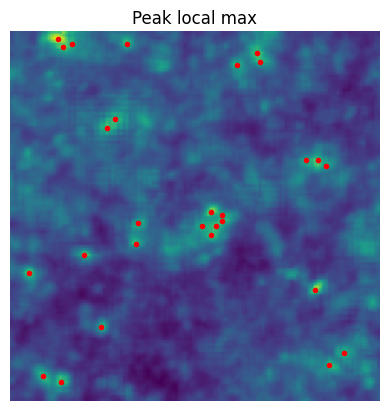

In [21]:
im = y_batch[0,:,:,0].numpy()

batch_mean, batch_std = grav_lens.utils.get_stats(y_batch)
coordinates = peak_local_max(im, min_distance=1, threshold_abs=batch_mean + 2*batch_std)

plt.imshow(im)
plt.autoscale(False)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
plt.axis('off')
plt.title('Peak local max')
plt.show()

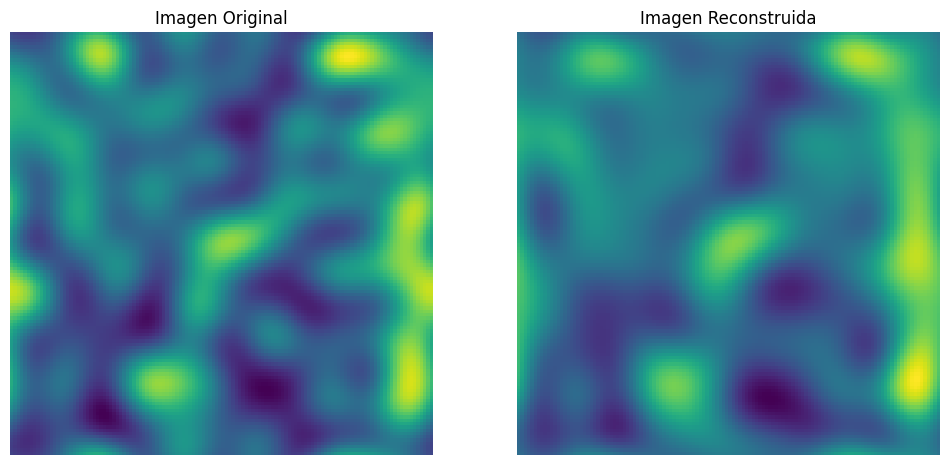

In [7]:
low_recon = reconstruct_lowfreq_from_pca(principal_components, 64, ipca_low)

idx = 0
original = low_batch[idx,:,:,0]
reconstructed = low_recon[idx,:,:,0]
gp.plot_comparison(original, reconstructed)

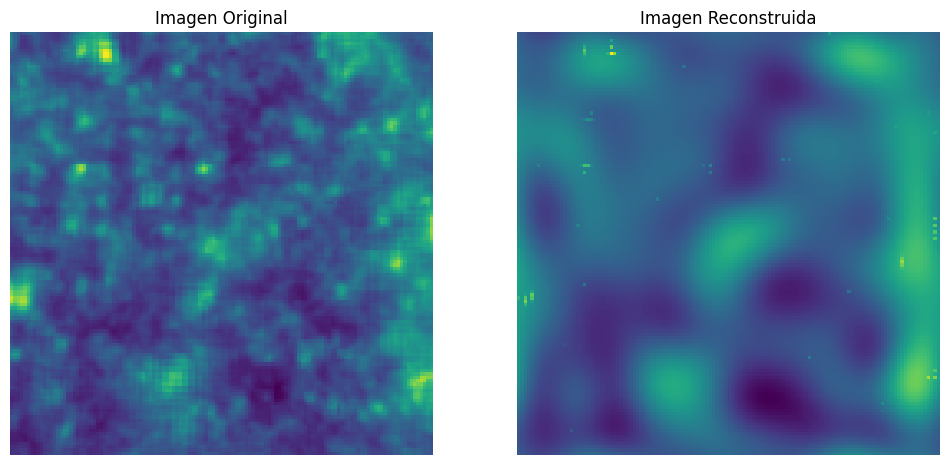

In [9]:
reconstructed_batch = reconstruct_batch_images(principal_components,gaussians,64, ipca_low)

idx = 0
original = y_batch[idx,:,:,0]
reconstructed = reconstructed_batch[idx,:,:,0]
gp.plot_comparison(original, reconstructed)

c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (29) found smaller than n_clusters (30). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (22) found smaller than n_clusters (30). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10

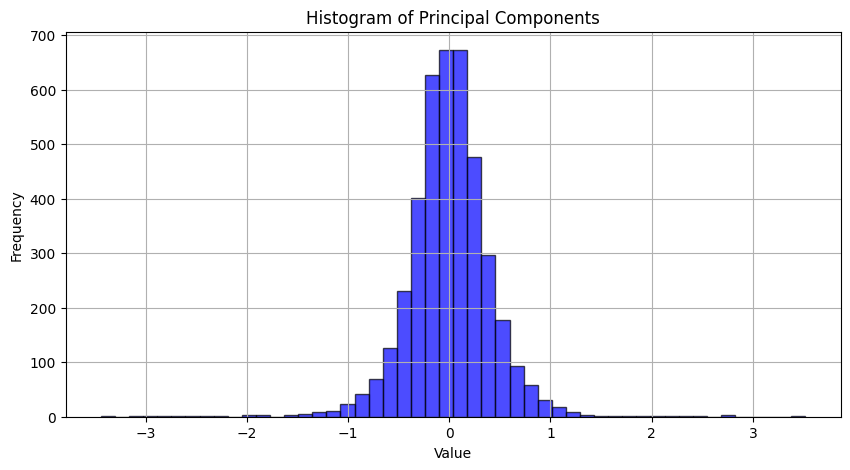

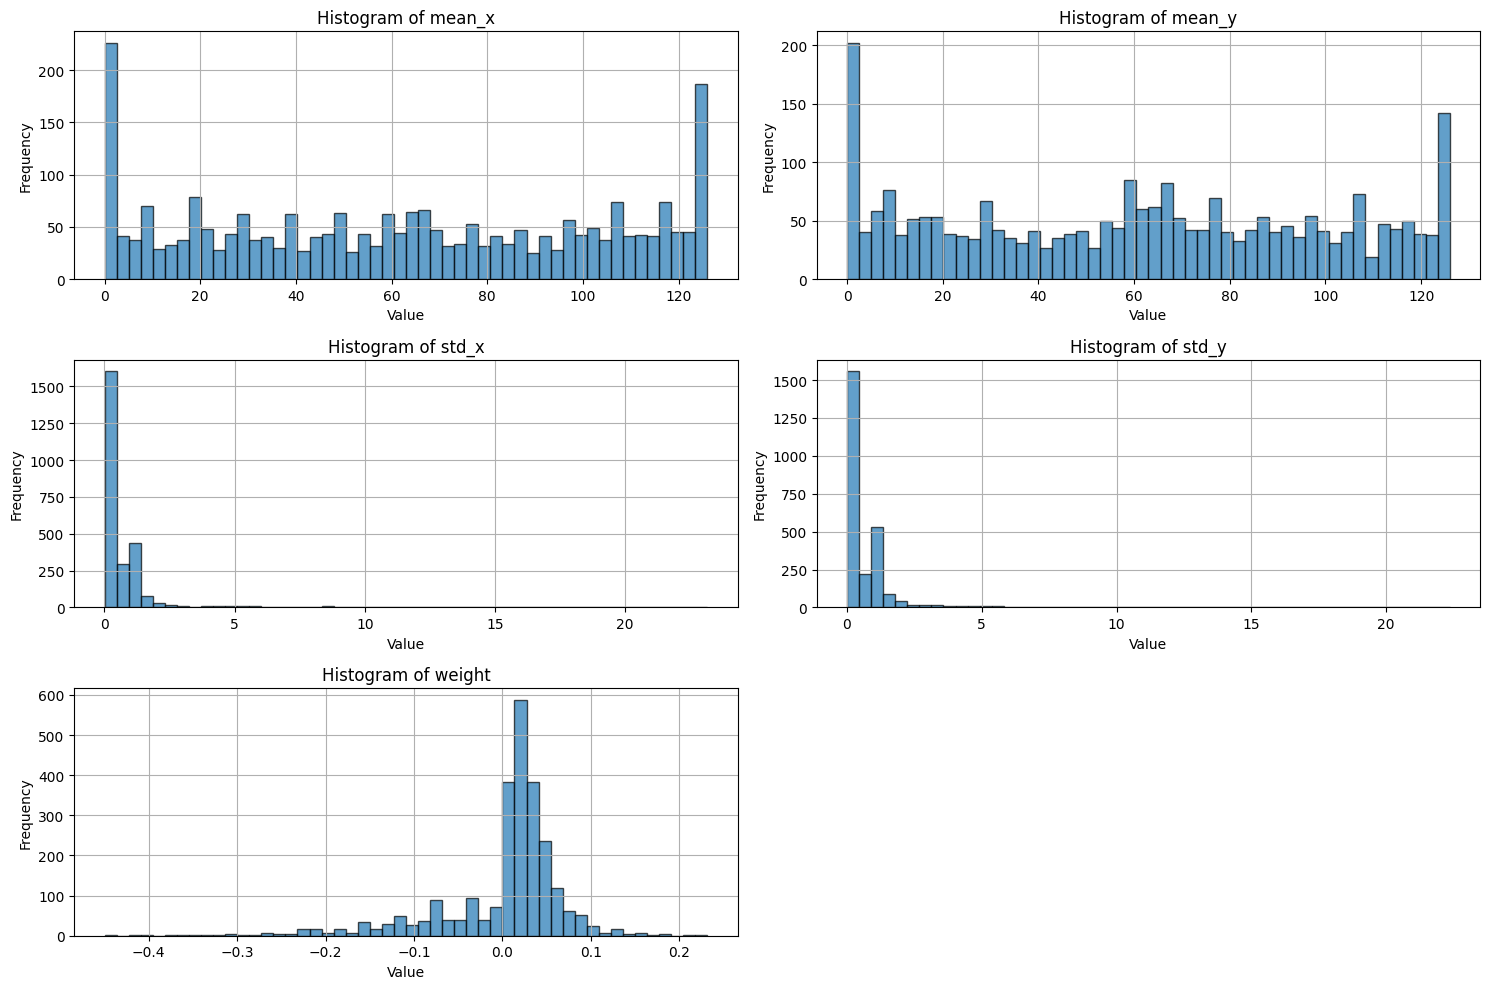

In [9]:
plot_histograms(*preprocess_ybatch(y_batch))

In [1]:
corte = 1.5

mean, std = gp.calculate_image_stats(high_batch)
pos_hb, neg_hb = gp.apply_threshold(high_batch[idx,:,:,0], mean, std, corte)

# se agregaron tecnicas de regularización
gaussians = gp.gmm_batch_vectors(high_batch, n_gaussians_positive=25, n_gaussians_negative=0, 
                                 threshold=corte, n_points=750, scale=0.75, density_threshold=0.02)

high_recon = reconstruct_highfreq_from_gmm(gaussians, 64)

idx = 0
original = pos_hb
reconstructed = high_recon[idx,:,:,0]
gp.plot_comparison(original, reconstructed)

NameError: name 'gp' is not defined

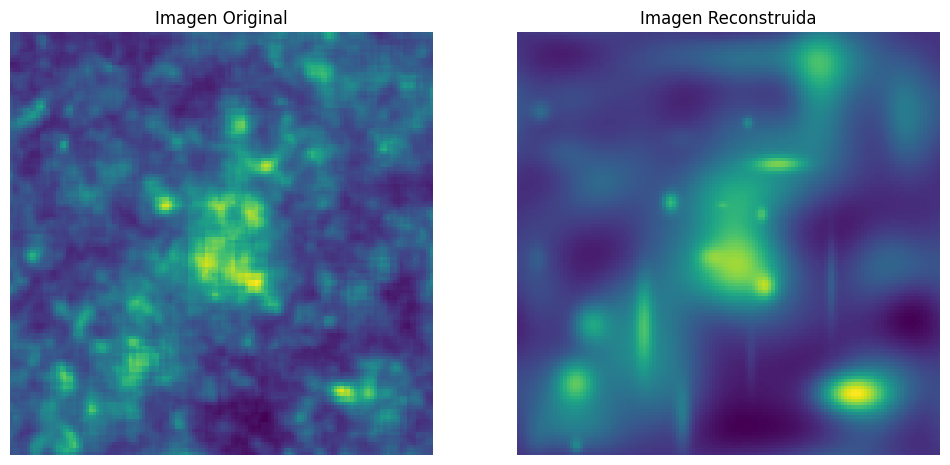